# 权重衰退 weight decay
权重衰退是最广泛使用的正则化技术之一

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

首先，我们[**像以前一样生成一些数据**]，生成公式如下：

**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**

我们选择标签是关于输入的线性函数。标签同时被均值为0，标准差为0.01高斯噪声破坏。为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d = 200$，并使用一个只包含20个样本的小训练集。

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

初始化模型参数

In [3]:
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)
    return [w,b]

定义$L_2$范数惩罚

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2))/2

定义训练代码实现

In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 500, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                # 增加了L2范数惩罚项，广播机制使l2_penalty(w)成为一个长度为`batch_size`的向量。
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 13.86440658569336


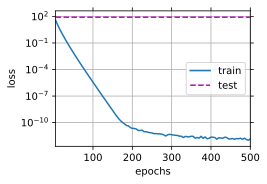

In [6]:
"""非常严重的过拟合"""
train(lambd=0)

w的L2范数是： 0.04069865867495537


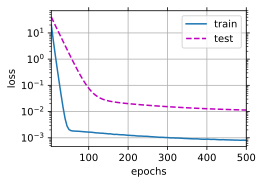

In [7]:
train(lambd = 3)

w的L2范数是： 0.02324616350233555


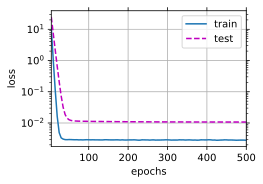

In [8]:
train(lambd = 10)

## 简洁实现

In [9]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减。
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': train_concise(0)},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

In [10]:
train_concise(0)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [ ]:
train_concise(3)